### Import libraries


In [32]:
import requests
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ssl
import matplotlib.ticker as mticker


### Fetch data from the API | Census

In [33]:
class TLSAdapter(requests.adapters.HTTPAdapter):
    def init_poolmanager(self, *args, **kwargs):
        ctx = ssl.create_default_context()
        ctx.set_ciphers("DEFAULT@SECLEVEL=1")
        ctx.options |= 0x4   # <-- the key part here, OP_LEGACY_SERVER_CONNECT
        kwargs["ssl_context"] = ctx
        return super(TLSAdapter, self).init_poolmanager(*args, **kwargs)

url_get_1872_2010 = 'https://servicodados.ibge.gov.br/api/v3/agregados/1286/periodos/1872|1890|1900|1920|1940|1950|1960|1970|1980|1991|2000|2010/variaveis/606?localidades=N3[all]'
url_get_2022 = 'https://servicodados.ibge.gov.br/api/v3/agregados/4712/periodos/2022/variaveis/382?localidades=N6[all]'

responses_data = {}

with requests.session() as s:
    s.mount("https://", TLSAdapter())
    
    # Requisição para o período 1872-2010
    response_1872_2010 = s.get(url_get_1872_2010)
    if response_1872_2010.status_code == 200:
        responses_data["1872_2010"] = response_1872_2010.json()
    else:
        print(f"Requisição 1872-2010 falhou com código {response_1872_2010.status_code}")

    # Requisição para 2022
    response_2022 = s.get(url_get_2022)
    if response_2022.status_code == 200:
        responses_data["2022"] = response_2022.json()
    else:
        print(f"Requisição 2022 falhou com código {response_2022.status_code}")

## Extrair os dados e converter em um DataFrame | 1872 até 2010

In [34]:
# Extrair os dados para 1872-2010
data_1872_2010 = responses_data["1872_2010"][0]['resultados'][0]['series']

# Converter os dados em um DataFrame
df_1872_2010 = pd.DataFrame(data_1872_2010)

# Extrair as informações de 'localidade' e 'serie' em colunas separadas
df_1872_2010['State'] = df_1872_2010['localidade'].apply(lambda x: x['nome'])
df_1872_2010 = pd.concat([df_1872_2010.drop(['serie'], axis=1), df_1872_2010['serie'].apply(pd.Series)], axis=1)

# Descartar a coluna 'localidade', pois não é mais necessária
df_1872_2010 = df_1872_2010.drop(['localidade'], axis=1)

df_1872_2010.head()

,State,1872,1890,1900,1920,1940,1950,1960,1970,1980,1991,2000,2010
0,Rondônia,-,-,-,-,-,36935,70783,116620,503125,1130874,1377792,1562409
1,Acre,-,-,-,92379,79768,114755,160208,218006,306893,417165,557226,733559
2,Amazonas,57610,147915,249756,363166,438008,514099,721215,960934,1449135,2102901,2813085,3483985
3,Roraima,-,-,-,-,-,18116,29489,41638,82018,215950,324152,450479
4,Pará,275237,328455,445356,983507,944644,1123273,1550935,2197072,3507312,5181570,6189550,7581051


In [35]:
# Map of state names to abbreviations
state_name_to_abbrev = {
    'Rondônia': 'RO', 'Acre': 'AC', 'Amazonas': 'AM', 'Roraima': 'RR',
    'Pará': 'PA', 'Amapá': 'AP', 'Tocantins': 'TO', 'Maranhão': 'MA',
    'Piauí': 'PI', 'Ceará': 'CE', 'Rio Grande do Norte': 'RN', 'Paraíba': 'PB',
    'Pernambuco': 'PE', 'Alagoas': 'AL', 'Sergipe': 'SE', 'Bahia': 'BA',
    'Minas Gerais': 'MG', 'Espírito Santo': 'ES', 'Rio de Janeiro': 'RJ',
    'São Paulo': 'SP', 'Paraná': 'PR', 'Santa Catarina': 'SC', 'Rio Grande do Sul': 'RS',
    'Mato Grosso do Sul': 'MS', 'Mato Grosso': 'MT', 'Goiás': 'GO', 'Distrito Federal': 'DF'
}

# Replace state names with abbreviations
df_1872_2010['State'] = df_1872_2010['State'].replace(state_name_to_abbrev)

# Sort dataframe by state abbreviations
df_1872_2010_sorted = df_1872_2010.sort_values(by='State').reset_index(drop=True)
print(df_1872_2010_sorted)

   State     1872     1890     1900     1920     1940     1950      1960  \
0     AC        -        -        -    92379    79768   114755    160208   
1     AL   348009   511440   649273   978748   951300  1093137   1271062   
2     AM    57610   147915   249756   363166   438008   514099    721215   
3     AP        -        -        -        -        -    37477     68889   
4     BA  1379616  1919802  2117956  3334465  3918112  4834575   5990605   
5     CE   721686   805687   849127  1319228  2091032  2695450   3337856   
6     DF        -        -        -        -        -        -    141742   
7     ES    82137   135997   209783   457328   790149   957238   1418348   
8     GO   160395   227572   255284   511919   661226  1010880   1626376   
9     MA   359040   430854   499308   874337  1235169  1583248   2492139   
10    MG  2039735  3184099  3594471  5888174  6763368  7782188   9960040   
11    MS        -        -        -        -   238640   309395    579652   
12    MT    

## Extrair os dados e converter em um DataFrame | 2022

In [36]:
# Extrair os dados para 2022
data_2022 = responses_data["2022"][0]['resultados'][0]['series']

# Converter os dados em um DataFrame
df_2022 = pd.DataFrame(data_2022)

# Extrair as informações de 'localidade' e 'serie' em colunas separadas
df_2022['State'] = df_2022['localidade'].apply(lambda x: x['nome'])
df_2022 = pd.concat([df_2022.drop(['serie'], axis=1), df_2022['serie'].apply(pd.Series)], axis=1)

# Descartar a coluna 'localidade', pois não é mais necessária
df_2022 = df_2022.drop(['localidade'], axis=1)

df_2022.head()

,State,2022
0,Alta Floresta D'Oeste - RO,21440
1,Ariquemes - RO,96152
2,Cabixi - RO,5351
3,Cacoal - RO,86494
4,Cerejeiras - RO,15798


In [37]:
# Extrair o nome do estado da coluna "State" e criar uma nova coluna "Estado"
df_2022['Estado'] = df_2022['State'].str.extract(r'-(\s\w\w)$')[0].str.strip()

# Agrupar por "Estado" e somar a população de 2022
df_2022_total = df_2022.groupby('Estado')['2022'].sum().reset_index()

# Converter a coluna "2022" para inteiros
df_2022["2022"] = df_2022["2022"].astype(int)

# Agrupar por "Estado" e somar a população de 2022
df_2022_total_corrected = df_2022.groupby('Estado')['2022'].sum().reset_index()

print(df_2022_total_corrected)


   Estado      2022
0      AC    824448
1      AL   3117345
2      AM   3929369
3      AP    729353
4      BA  14103181
5      CE   8771496
6      DF   2792811
7      ES   3808060
8      GO   7022513
9      MA   6759838
10     MG  20436535
11     MS   2737054
12     MT   3635989
13     PA   8088984
14     PB   3959587
15     PE   9018330
16     PI   3263283
17     PR  11390719
18     RJ  15991284
19     RN   3291201
20     RO   1572676
21     RR    622859
22     RS  10816723
23     SC   7573632
24     SE   2201997
25     SP  44117616
26     TO   1506137


In [38]:
# Merge the dataframes
merged_df = pd.merge(df_1872_2010_sorted, df_2022_total_corrected, left_on='State', right_on='Estado', how='left').drop('Estado', axis=1)
print(merged_df)

   State     1872     1890     1900     1920     1940     1950      1960  \
0     AC        -        -        -    92379    79768   114755    160208   
1     AL   348009   511440   649273   978748   951300  1093137   1271062   
2     AM    57610   147915   249756   363166   438008   514099    721215   
3     AP        -        -        -        -        -    37477     68889   
4     BA  1379616  1919802  2117956  3334465  3918112  4834575   5990605   
5     CE   721686   805687   849127  1319228  2091032  2695450   3337856   
6     DF        -        -        -        -        -        -    141742   
7     ES    82137   135997   209783   457328   790149   957238   1418348   
8     GO   160395   227572   255284   511919   661226  1010880   1626376   
9     MA   359040   430854   499308   874337  1235169  1583248   2492139   
10    MG  2039735  3184099  3594471  5888174  6763368  7782188   9960040   
11    MS        -        -        -        -   238640   309395    579652   
12    MT    

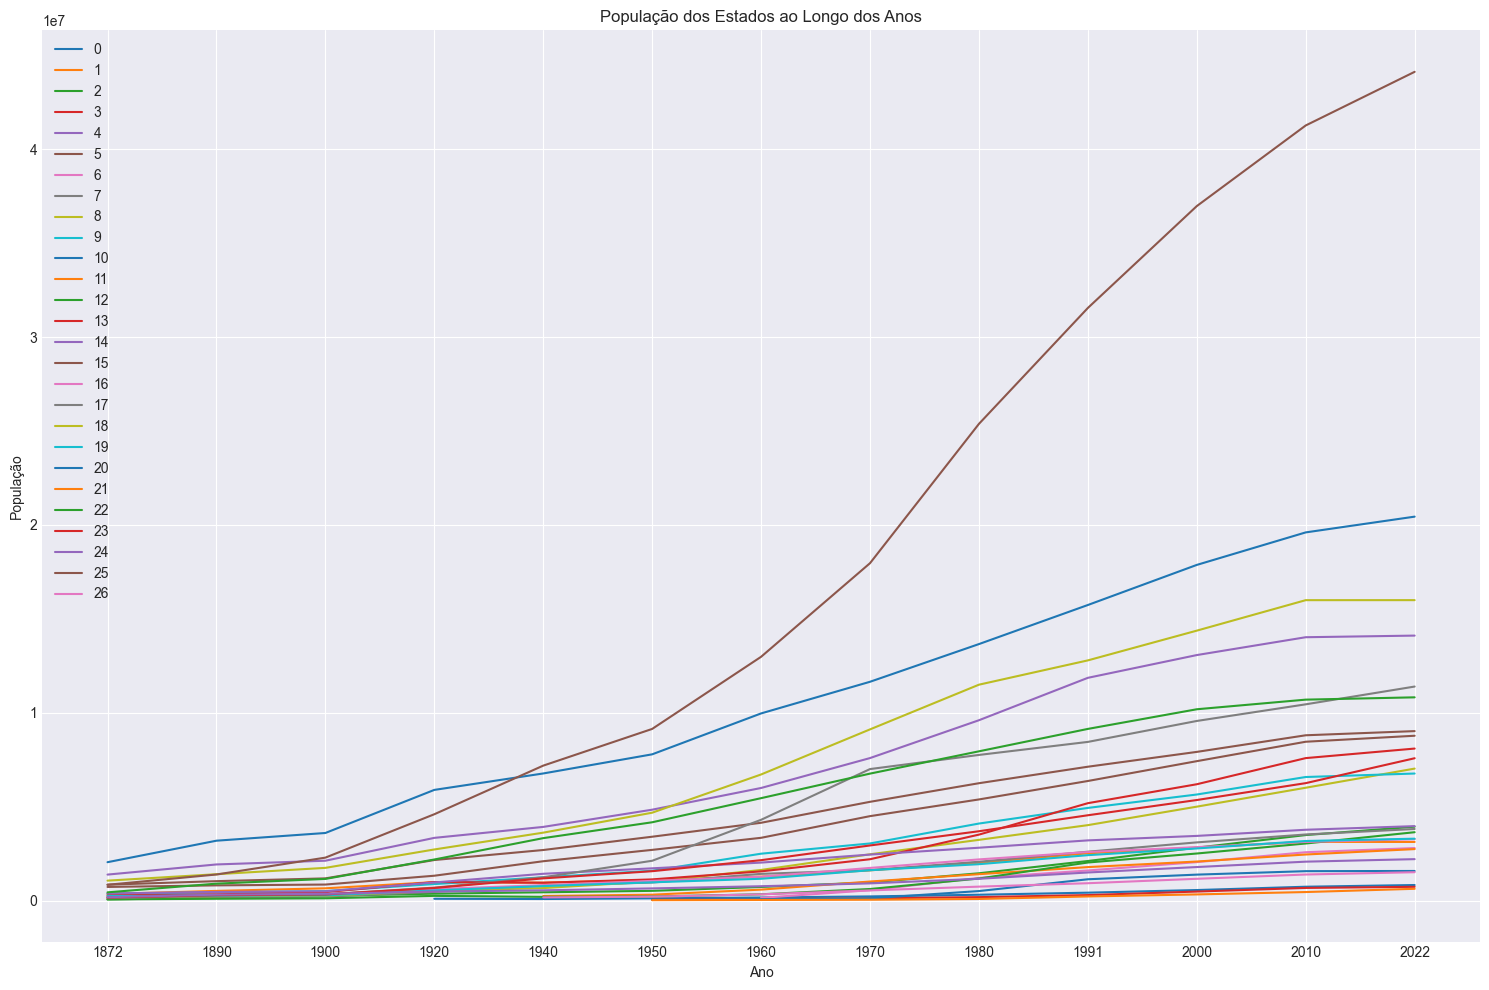

In [39]:
# Substituir "-" por NaN nas colunas de dados (anos)
merged_df.replace("-", np.nan, inplace=True)

# Converter apenas as colunas de anos para float
for column in merged_df.columns[1:]:  # Isso ignora a primeira coluna, que deve ser a dos estados
    merged_df[column] = merged_df[column].astype(float)

# Agora plote os dados
plt.figure(figsize=(15, 10))
for state in merged_df.index:
    plt.plot(merged_df.columns[1:], merged_df.loc[state, merged_df.columns[1:]], label=state)

plt.title('População dos Estados ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('População')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


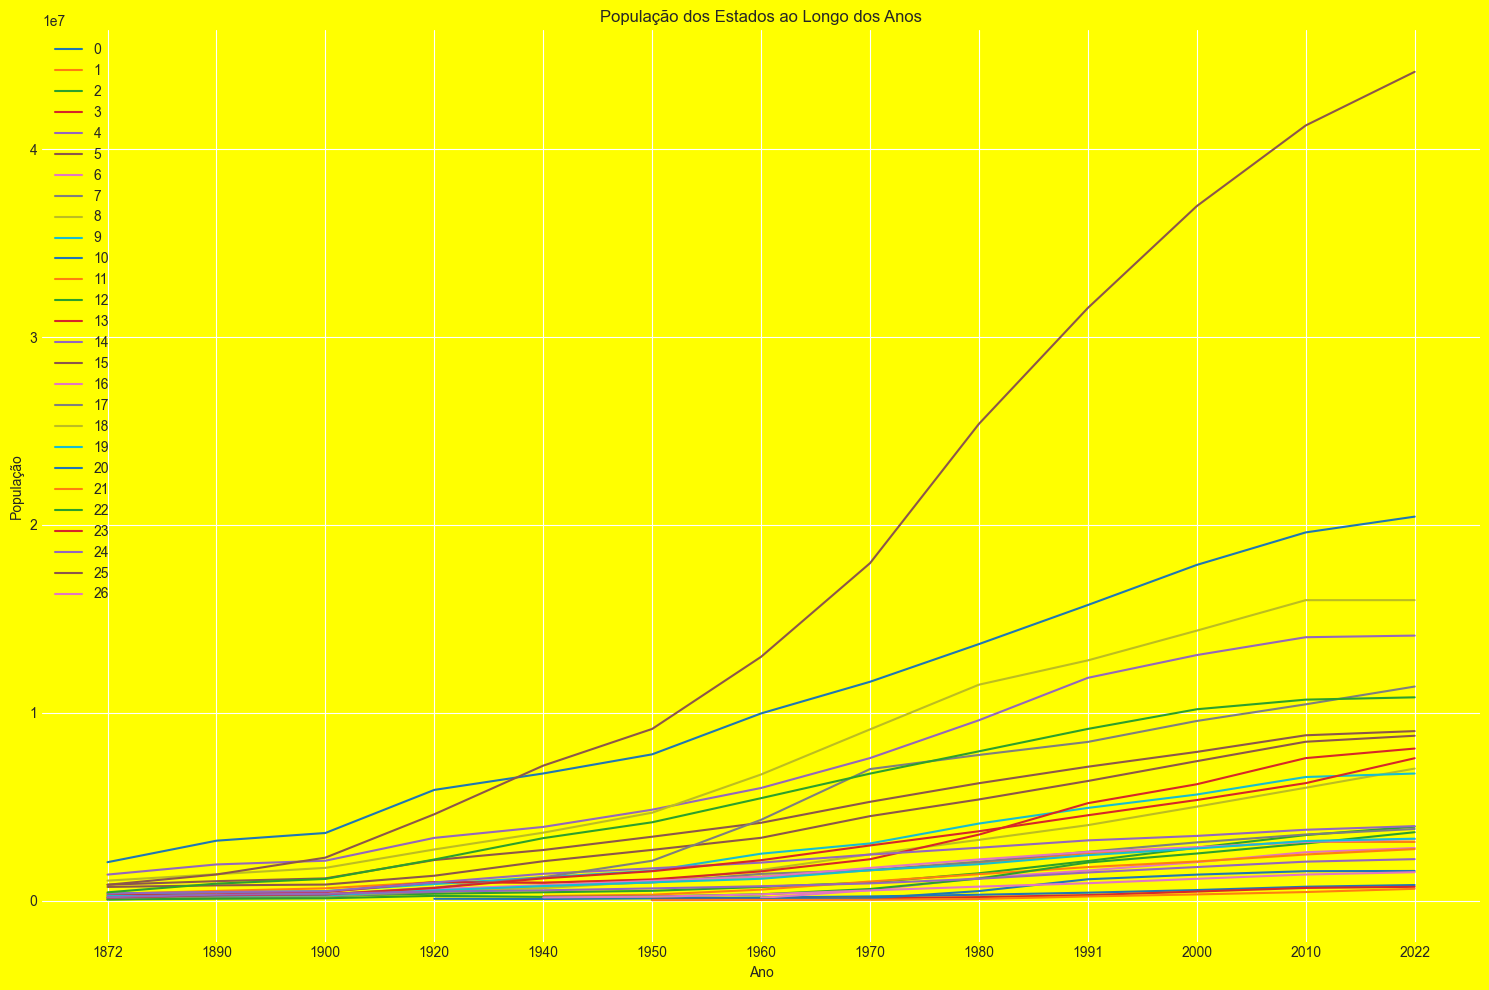

In [40]:
# Substituir "-" por NaN nas colunas de dados (anos)
merged_df.replace("-", np.nan, inplace=True)

# Converter apenas as colunas de anos para float
for column in merged_df.columns[1:]:  # Isso ignora a primeira coluna, que deve ser a dos estados
    merged_df[column] = merged_df[column].astype(float)

# Agora plote os dados
plt.figure(figsize=(15, 10))
ax = plt.gca()  # Get current axis
ax.set_facecolor('yellow')  # Plot area background color
plt.gcf().set_facecolor('yellow')  # Figure background color
for state in merged_df.index:
    plt.plot(merged_df.columns[1:], merged_df.loc[state, merged_df.columns[1:]], label=state)

plt.title('População dos Estados ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('População')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
cols_to_convert = merged_df.columns[merged_df.columns != 'State']
merged_df[cols_to_convert] = merged_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')


In [42]:
print(totals)# Transformando 'totals' em um DataFrame
totals_df = pd.DataFrame({'Year': totals.index, 'Total': totals.values})

# Salvando em um arquivo CSV
totals_df.to_csv('totals.csv', index=False)


1872      9930478.0
1890     14333915.0
1900     17438434.0
1920     30635605.0
1940     41236315.0
1950     51944397.0
1960     70992343.0
1970     94508583.0
1980    121150573.0
1991    146917459.0
2000    169590693.0
2010    190755799.0
2022    202083020.0
dtype: float64


In [43]:
totals = merged_df.drop('State', axis=1).sum()
print(totals)
totals.to_csv('totals.csv', index=False)

1872      9930478.0
1890     14333915.0
1900     17438434.0
1920     30635605.0
1940     41236315.0
1950     51944397.0
1960     70992343.0
1970     94508583.0
1980    121150573.0
1991    146917459.0
2000    169590693.0
2010    190755799.0
2022    202083020.0
dtype: float64


C:\Users\jlfen\AppData\Local\Temp\ipykernel_9956\3322011874.py:8: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



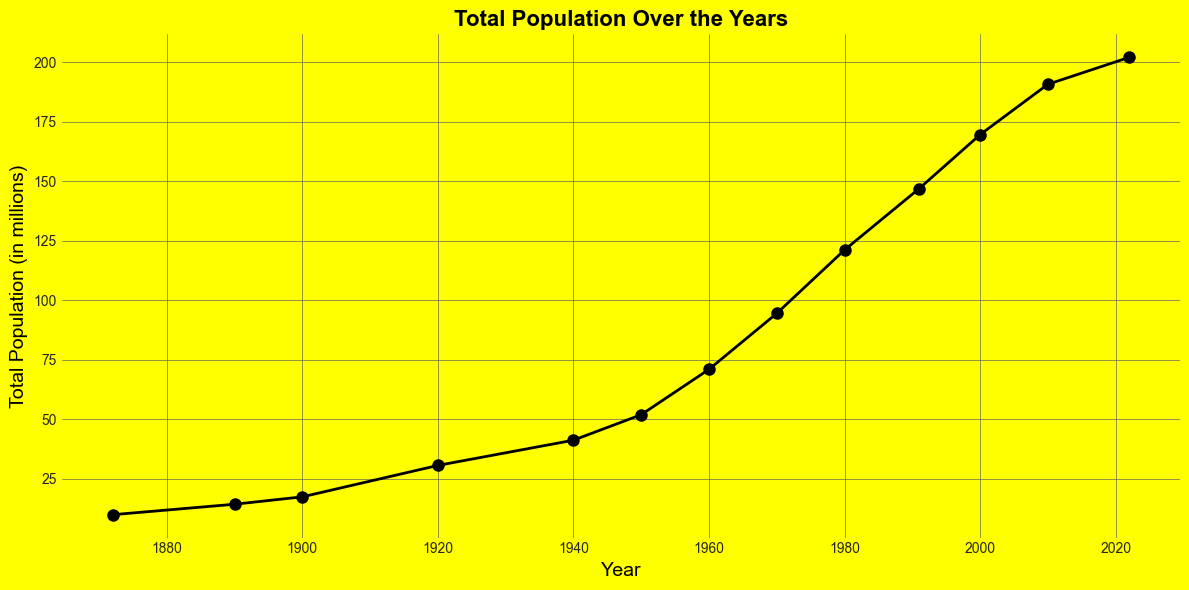

In [47]:
import plotly.express as px

# Suponhamos que 'totals' seja o seu DataFrame
# Convert the index of totals (which are the years) to integer for better plotting
totals.index = totals.index.astype(int)

# Use um estilo de gráfico moderno
plt.style.use('seaborn-darkgrid')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(totals.index, totals.values / 1_000_000, marker='o', markersize=8, color='black', linestyle='-', linewidth=2)
plt.title('Total Population Over the Years', fontsize=16, color='black', fontweight='bold')
plt.xlabel('Year', fontsize=14, color='black')
plt.ylabel('Total Population (in millions)', fontsize=14, color='black')

# Setting background and plot area colors
ax = plt.gca()
ax.set_facecolor('yellow')  # Plot area background color
plt.gcf().set_facecolor('yellow')  # Figure background color

# Adjust the y-axis to not use scientific notation
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Hide the right and top spines (secondary axes)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Customize grid lines
ax.grid(True, which='major', color='#666666', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()



In [53]:
import plotly.express as px

# Suponhamos que 'totals' seja o seu DataFrame
# Convertendo o índice (anos) para int
totals.index = totals.index.astype(int)

# Criando o gráfico com Plotly
fig = px.line(totals, x=totals.index, y=totals.values / 1_000_000,
              title='Total Population Over the Years',
              labels={'y': 'Total Population (in millions)', 'x': 'Year'})

# Personalizando o gráfico
fig.update_traces(marker=dict(size=8, color='black'),
                  line=dict(color='black', width=2))
fig.update_layout(
    template='plotly_dark',
    plot_bgcolor='yellow',
    paper_bgcolor='yellow',
    xaxis=dict(
        title='Year',
        showgrid=True,
        gridcolor='#666666',
        gridwidth=0.5,
        title_font=dict(color='black'),
        tickfont=dict(color='black')
    ),
    yaxis=dict(
        title='Total Population (in millions)',
        showgrid=True,
        gridcolor='#666666',
        gridwidth=0.5,
        title_font=dict(color='black'),
        tickfont=dict(color='black')
    ),
    yaxis_tickformat=',.0f',
    title_font=dict(color='black', size=18)  # Ajustando o tamanho da fonte do título
)

# Mostrando o gráfico
fig.show()

# Para salvar o gráfico como HTML
fig.write_html("C:\\Users\\jlfen\OneDrive\\Documentos\\JoaoKasten\\005_applied_projects\\project.censo-dataviz\\graph_in_html\\population_over_years.html")


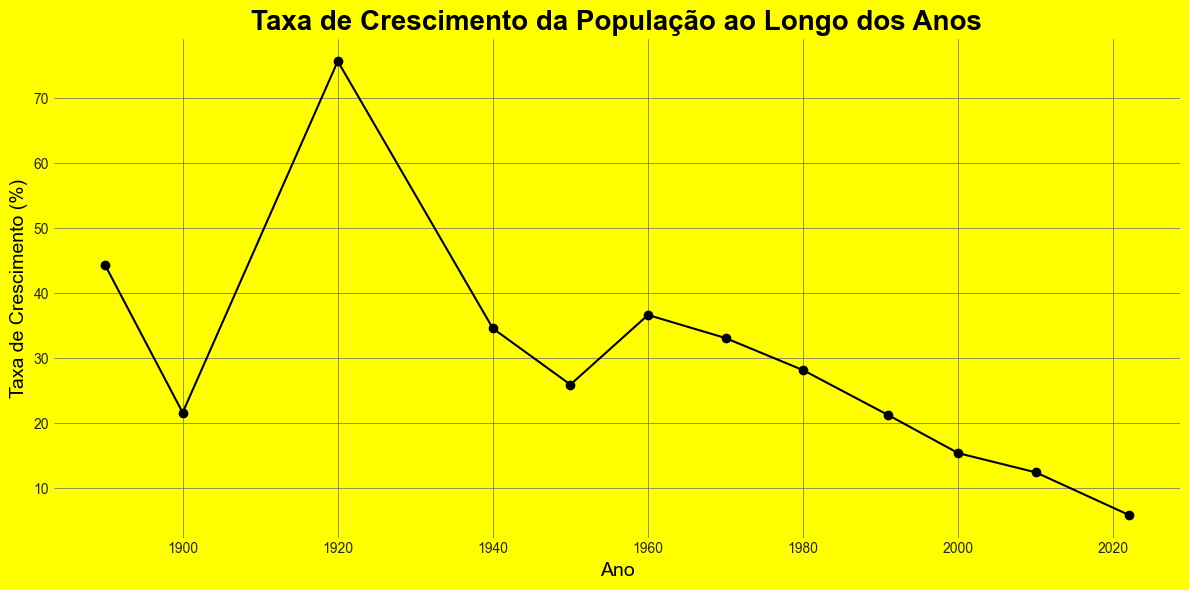

In [45]:
# Calcular a taxa de crescimento anual
growth_rate = ((totals / totals.shift(1)) ** (1/1)) - 1

# Plotar o gráfico da taxa de crescimento
plt.figure(figsize=(12, 6))
plt.plot(growth_rate.index, growth_rate.values * 100, marker='o', color='black', linestyle='-')  # Multiplicar por 100 para converter para porcentagem
plt.title('Taxa de Crescimento da População ao Longo dos Anos', fontsize=20, color='black', fontweight='bold')
plt.xlabel('Ano', fontsize=14, color='black')
plt.ylabel('Taxa de Crescimento (%)', fontsize=14, color='black')

# Definindo as cores de fundo
ax = plt.gca()
ax.set_facecolor('yellow')  # Cor de fundo da área de plotagem
plt.gcf().set_facecolor('yellow')  # Cor de fundo da figura

# Ajustar o eixo y para não usar notação científica
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Esconder os eixos secundários à direita e acima
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Personalizar as linhas de grade
ax.grid(True, which='major', color='#666666', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()


In [46]:
print(growth_rate)

1872         NaN
1890    0.443426
1900    0.216586
1920    0.756786
1940    0.346026
1950    0.259676
1960    0.366699
1970    0.331250
1980    0.281900
1991    0.212685
2000    0.154326
2010    0.124801
2022    0.059381
dtype: float64
